In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision  import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim 
from torchmetrics.classification  import MulticlassAccuracy, MulticlassF1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

## Data procssesing

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),              
    transforms.RandomRotation(15),                       
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [5]:
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(len(train_dataset),len(test_dataset))

50000 10000


In [8]:
test_dataset, val_dataset = random_split(test_dataset,[7000, 3000])

In [9]:
len(test_dataset)

7000

In [10]:
train = DataLoader(train_dataset, batch_size=64, shuffle=True)
test = DataLoader(test_dataset)
val = DataLoader(val_dataset,batch_size=500)

## sampling

In [19]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
instance = transforms.Compose({
    transforms.ToTensor()
})

In [12]:
for_instance_dataset = datasets.CIFAR10('/data', train=True, download=True, transform=instance)

100%|██████████| 170498071/170498071 [07:11<00:00, 395318.13it/s]


Extracting /data\cifar-10-python.tar.gz to /data


In [13]:
for_instance = DataLoader(for_instance_dataset, batch_size=64, shuffle=True)

torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])


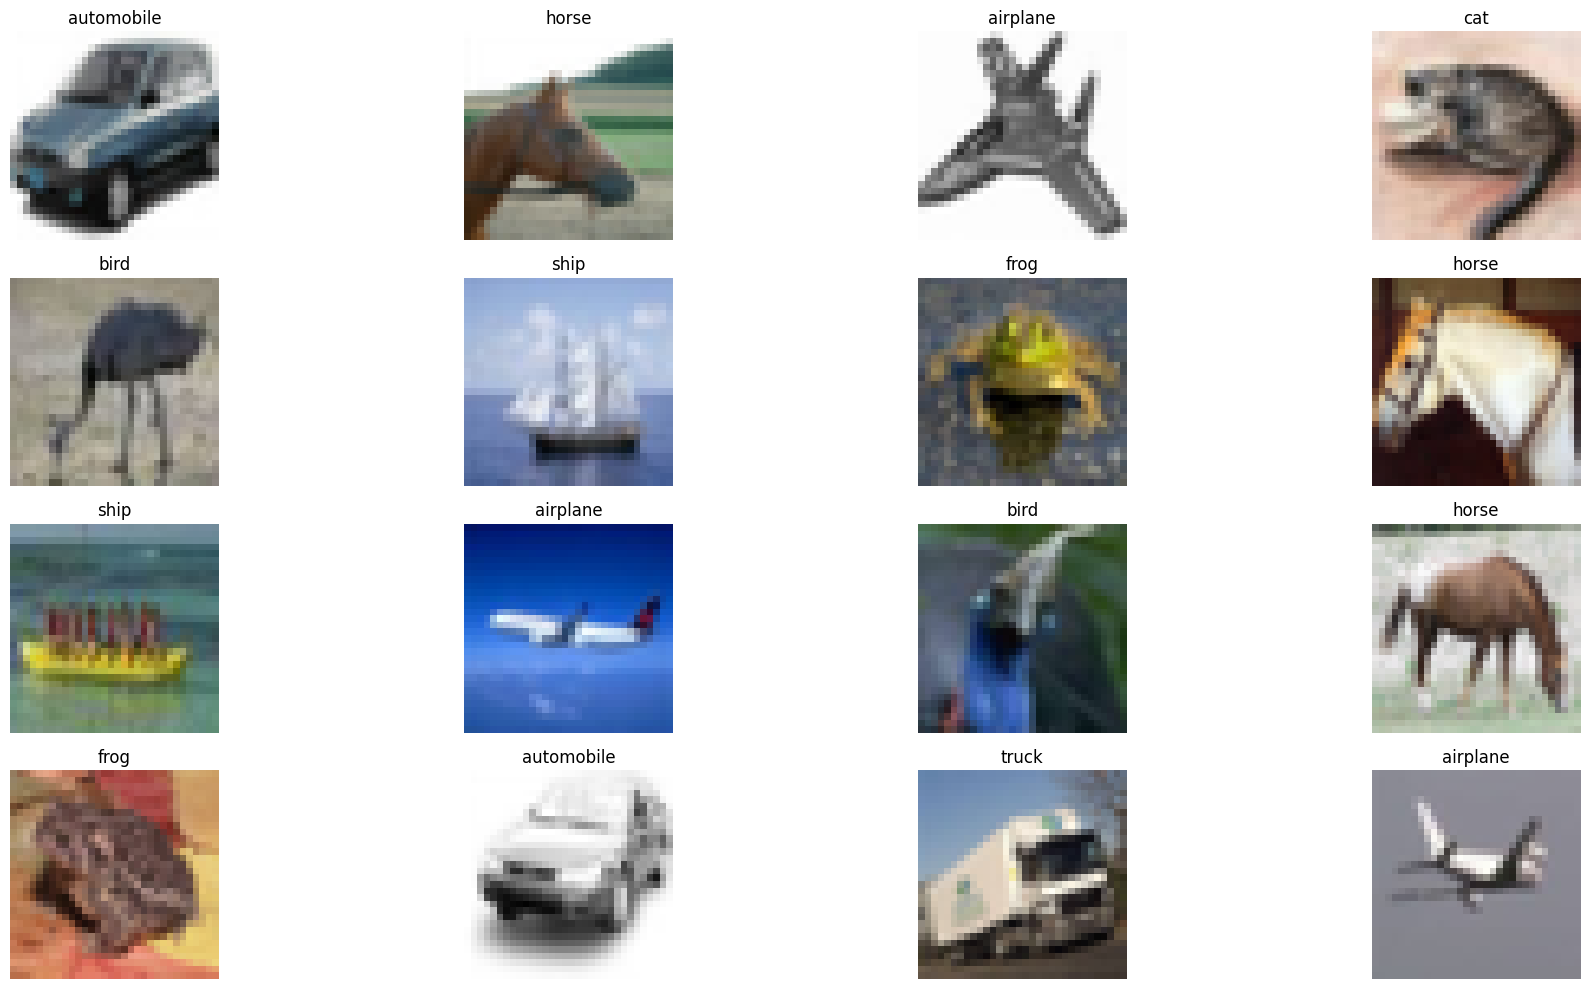

In [21]:
images, labels = next(iter(for_instance))

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].permute(1, 2, 0)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')
    print(img.size())

plt.tight_layout()
plt.show()


## Define Model

In [65]:
class CIFARClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.CNN_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.2)

        )

        self.FC_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    def forward(self, x) : 
        x = self.CNN_layer(x)
        x = self.FC_layer(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFARClassifier().to(device=device)

In [ ]:

lossf = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005)

In [72]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [67]:
device

device(type='cuda')

In [74]:
for epoch in range(15):
    train_loss = 0
    model.train()
    for i, data in enumerate(train):
        image, label = data
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        model.train()

        preds = model(image)
        loss = lossf(preds,label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_loss=0
        F1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
        Accurucy = MulticlassAccuracy(num_classes=10, average='macro').to(device)
        for images , labels in val:
            images, labels = images.to(device), labels.to(device)
            val_pred = model(images)
            loss = lossf(val_pred, labels)
            val_loss+=loss.item()
            F1.update(preds=val_pred, target=labels)
            Accurucy.update(preds=val_pred, target=labels)
        print(f"val_loss: {val_loss/6} | train_loss (epoch_final):{train_loss/len(train)} | val_accurucy: {Accurucy.compute()} | val_F1: {F1.compute()}")

val_loss: 0.6398739814758301 | train_loss (epoch_final):0.9346171321771334 | val_accurucy: 0.7734823822975159 | val_F1: 0.7703866362571716
val_loss: 0.6149740119775137 | train_loss (epoch_final):0.9082510933241881 | val_accurucy: 0.7931605577468872 | val_F1: 0.7888310551643372
val_loss: 0.6237241725126902 | train_loss (epoch_final):0.8968702461713415 | val_accurucy: 0.7868355512619019 | val_F1: 0.7841901779174805
val_loss: 0.6215489506721497 | train_loss (epoch_final):0.8868835574525702 | val_accurucy: 0.7893674373626709 | val_F1: 0.7870191335678101
val_loss: 0.6032963593800863 | train_loss (epoch_final):0.8748071277919023 | val_accurucy: 0.7975505590438843 | val_F1: 0.79451584815979
val_loss: 0.6288413405418396 | train_loss (epoch_final):0.8684904461778948 | val_accurucy: 0.7874616384506226 | val_F1: 0.7850815653800964
val_loss: 0.6030531227588654 | train_loss (epoch_final):0.8702083345874191 | val_accurucy: 0.7951033115386963 | val_F1: 0.7921791076660156
val_loss: 0.5743755996227264 

In [75]:
with torch.no_grad():
    F1_test= MulticlassF1Score(num_classes=10, average='macro').to(device)
    Accurucy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
    cf = ConfusionMatrix(task = 'multiclass',num_classes=10).to(device)
    model.eval()
    for images , labels in test:
        images, labels = images.to(device), labels.to(device)
        test_preds = model(images)
        F1_test.update(preds=test_preds, target=labels)
        Accurucy_test.update(preds=test_preds, target=labels)
        cf.update(test_preds,labels)
    
    print(f"test -> accurucy: {Accurucy_test.compute():.4f} | F1: {F1_test.compute():.4f}")


test -> accurucy: 0.8191 | F1: 0.8154


<Axes: >

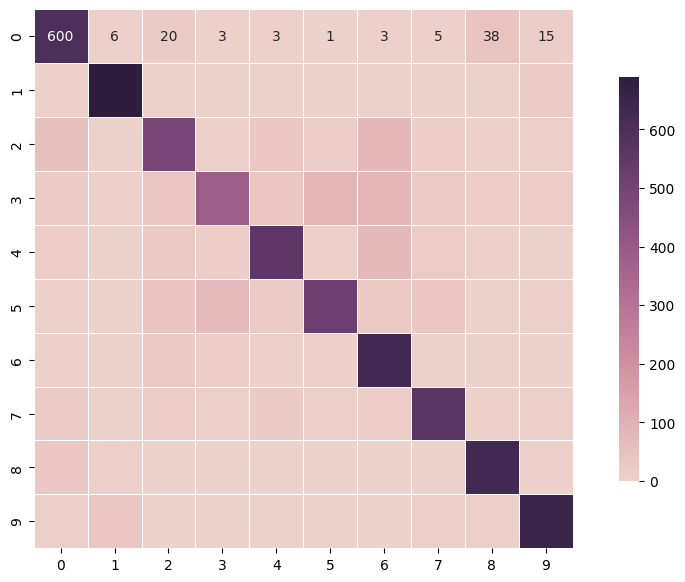

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.heatmap(cf.compute().to('cpu'),
            annot=True, 
            fmt='d', 
            cmap=sns.cubehelix_palette(as_cmap=True), 
            linewidths=0.5, 
            square=True, 
            cbar_kws={"shrink": 0.75})

## Result

| Epoch | Val Loss | Train Loss (Final) | Val Accuracy | Val F1 Score |
|-------|----------|---------------------|--------------|--------------|
| 1     | 0.6399   | 0.9346              | 0.7735       | 0.7704       |
| 2     | 0.6150   | 0.9083              | 0.7932       | 0.7888       |
| 3     | 0.6237   | 0.8969              | 0.7868       | 0.7842       |
| 4     | 0.6215   | 0.8869              | 0.7894       | 0.7870       |
| 5     | 0.6033   | 0.8748              | 0.7976       | 0.7945       |
| 6     | 0.6288   | 0.8685              | 0.7875       | 0.7851       |
| 7     | 0.6031   | 0.8702              | 0.7951       | 0.7922       |
| 8     | 0.5744   | 0.8666              | 0.8066       | 0.8044       |
| 9     | 0.5909   | 0.8635              | 0.7979       | 0.7951       |
| 10    | 0.5931   | 0.8568              | 0.7989       | 0.7965       |
| 11    | 0.5760   | 0.8511              | 0.8040       | 0.8013       |
| 12    | 0.5611   | 0.8515              | 0.8092       | 0.8061       |
| 13    | 0.5769   | 0.8427              | 0.8069       | 0.8040       |
| 14    | 0.5896   | 0.8446              | 0.7989       | 0.7965       |
| 15    | 0.5691   | 0.8353              | 0.8063       | 0.8026       |


## Final result
  - Test Accuracy: 0.8191
  - Test F1 : 0.8154

## saving model

In [77]:
torch.save(model.state_dict(), 'CIFAR_10.pt')